In [1]:
# Importar librerías para análisis y manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Preparación de datos y partición
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Modelo Random Forest
from sklearn.tree import DecisionTreeRegressor

# Evaluación del modelo
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, make_scorer, r2_score

In [2]:
df = pd.read_csv('/kaggle/input/viviendas-modelos/viviendas_model.csv')

In [3]:
# df = df.drop([
#     'Paro hombre edad < 25',
#     'Paro hombre edad >=45',
#     'Paro mujer edad < 25',
#     'Paro mujer edad 25 -45 ',
#     'Paro Agricultura',
#     'Paro Industria',
#     'Paro construccion',
#     'Paro Servicios',
#     'Paro Sin empleo Anterior',
#     'Mediana de la renta por unidad de consumo',
#     'Renta bruta media por persona',
#     'Renta neta media por persona ',
#     'Renta bruta media por hogar',
#     'total Paro Registrado']
#         ,axis=1)

In [4]:
# Verificar si hay datos faltantes
def check_missing_data(df):
    hay_nan = df.isnull().values.any()
    print(f"¿Hay algún NaN en el DataFrame? {hay_nan}")

    nan_por_columna = df.isnull().sum()
    print("Cantidad de NaN por columna:\n", nan_por_columna)

    filas_con_nan = df[df.isnull().any(axis=1)]
    print("Filas que contienen NaN:\n", filas_con_nan)

    return hay_nan, nan_por_columna, filas_con_nan

In [5]:
hay_nan, nan_por_columna, filas_con_nan = check_missing_data(df)
if hay_nan:
    df = df.dropna()
hay_nan, nan_por_columna, filas_con_nan = check_missing_data(df)

¿Hay algún NaN en el DataFrame? True
Cantidad de NaN por columna:
 Caracteristicas                              0
Habitaciones                                 0
Aseos                                        0
Terraza                                      0
Piscina                                      0
Garaje                                       0
Precio                                       0
Metros                                       0
CodigoPostal                                 1
Latitud                                      0
Longitud                                     0
Mediana de la renta por unidad de consumo    0
Renta bruta media por hogar                  0
Renta bruta media por persona                0
Renta neta media por persona                 0
total Paro Registrado                        0
Paro hombre edad < 25                        0
Paro hombre edad >=45                        0
Paro mujer edad < 25                         0
Paro mujer edad 25 -45                  

In [6]:
# Características y etiqueta
X = df.drop('Precio', axis=1)
y = df['Precio']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=101)

# Guardar los índices originales de X_test antes de escalar
X_test_indices = X_test.index

# Escalado de características
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test_indices, columns=X_test.columns)

In [8]:
# Crear el modelo Random Forest
dt_model = DecisionTreeRegressor(random_state=42)

In [9]:
# Crear un KFold para la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar el modelo utilizando la validación cruzada
cv_results = cross_val_score(dt_model, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')

# Calcular la media y la desviación estándar del MSE
mean_mse = np.mean(np.abs(cv_results))
std_mse = np.std(cv_results)

print(f'Mean MSE: {mean_mse}')
print(f'Standard Deviation of MSE: {std_mse}')

Mean MSE: 76807508.1192495
Standard Deviation of MSE: 9128777.747213423


In [10]:
param_grid = {
    'max_depth': [3, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crear el GridSearchCV
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Ajustar el GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Mejor combinación de hiperparámetros
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.2s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.2s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END max_depth=3, min_samples_l

In [11]:
# Evaluar el mejor modelo
best_dt_model = grid_search.best_estimator_

# Evaluar en el conjunto de prueba
best_test_predictions = best_dt_model.predict(X_test_scaled)
best_test_mse = mean_squared_error(y_test, best_test_predictions)
best_test_rmse = np.sqrt(best_test_mse)

print(f'Best Test MSE: {best_test_mse}')
print(f'Best Test RMSE: {best_test_rmse}')

Best Test MSE: 129719349.85106012
Best Test RMSE: 11389.44027821649


In [12]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    
    print(f'R2: {r2}')
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    
    # Grafica de la dispersión y la línea de regresión
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, color='blue', alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
    plt.xlabel('Valores Reales')
    plt.ylabel('Valores Predichos')
    plt.title('Valores Reales vs. Valores Predichos')
    plt.grid(True)
    plt.savefig('/kaggle/working/regression_plot.png')
    plt.show()

R2: 0.9971847044453278
MAE: 2754.8767876341967
MSE: 129719349.85106012


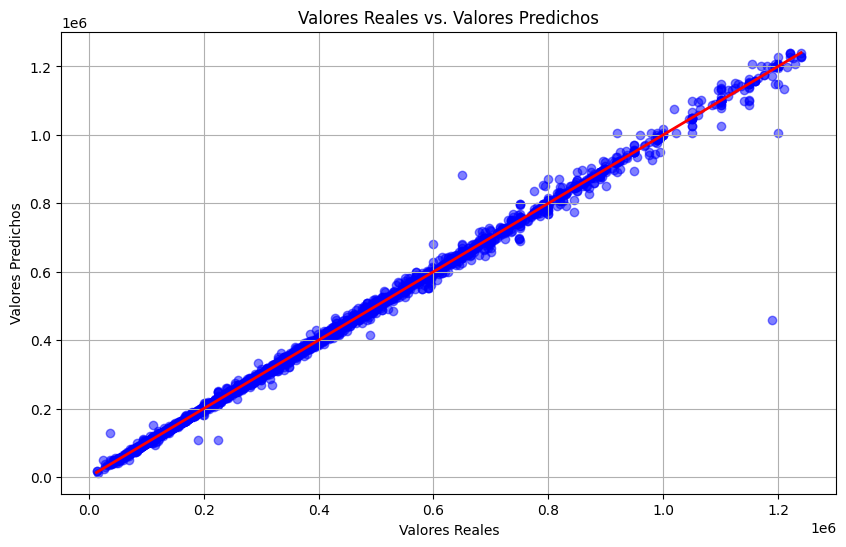

In [13]:
evaluate(best_dt_model, X_test_scaled, y_test)

In [14]:
# Seleccionar aleatoriamente un inmueble del conjunto de prueba
random_inmueble_index = np.random.choice(X_test_indices)
random_inmueble = X_test_scaled_df.loc[random_inmueble_index].values.reshape(1, -1)
precio_predicho = best_dt_model.predict(random_inmueble)

precio_real = y_test.loc[random_inmueble_index]

# Imprimir el precio real y el precio predicho
print(f'El precio real del inmueble seleccionado aleatoriamente es: {precio_real}')
print(f'El precio predicho del inmueble seleccionado aleatoriamente es: {precio_predicho[0]}')


El precio real del inmueble seleccionado aleatoriamente es: 345000.0
El precio predicho del inmueble seleccionado aleatoriamente es: 345000.0
